Laura Dahlberg
---
Building a neural network from scratch with weed detection in soy beans crop dataset

In [1]:
## for graphs to appear in the same cell
%matplotlib inline

## for the notebook to reload external modules
%reload_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
from pathlib import Path
import os


In [3]:
#setting default size of plots
plt.rcParams['figure.figsize'] = (15.0, 15.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'


## data exploration
---

In [ ]:
## download & unzip dataset from https://www.kaggle.com/fpeccia/weed-detection-in-soybean-crops
ROOT = Path(r'C:\enter\your\project\rooth_path\here') ##replace this for your project's real path
DATA = ROOT/'weed-detection-in-soybean-crops\dataset'
print(ROOT)
print(DATA)

In [6]:
# this will discover the classes for you
# how many unique classes, checking that there are only 4
all_files_classes = [str(f).split('\\')[-2] for f in DATA.rglob('*.tif') if (f.is_file())]
classes = list(set(all_files_classes))
classes    

['grass', 'broadleaf', 'soil', 'soybean']

## background
1. Y is always the label(s), X is always the features (the data describing the label)

In [7]:
num_file = 1100 ## per class
all_files = []
num_data = num_file*len(classes)
## creating an array of zeros as a placeholder for the predicted data
Y = np.zeros(num_data)

## image dimensions
im_width = 200
im_height = 200
im_channel = 3
dim = im_width * im_height * im_channel

## creating a list with the first 1100 files of each plant class( or directory)
## the "=+" adds up to the list with each iteration
## 3rd line assigns a # (0, 1, 2, or 3) to each set of 1100 files,
## each set is one category
for i, cls in enumerate(classes):
    all_files += [str(f) for f in DATA.rglob('*.tif') if (f.is_file())][:num_file]
    Y[i*num_file:(i+1)*num_file] = i
#print(Y.size)

## preprocessing
---

In [8]:
# let's look at one file

# image shape BEFORE normalizing the shape for GPUs (187, 201, 3)
print('this is the shape of file 0:', cv2.imread(all_files[0]).shape)

# Resizing the files to consistent sizes for efficient processing (200x200)
print('resizing image to 200x200:', cv2.resize(cv2.imread(all_files[0]), (im_width, im_height)).shape)

print('image 0 is between', cv2.resize(cv2.imread(all_files[0]), (im_width, im_height))[0].min(), 
      cv2.resize(cv2.imread(all_files[0]),  (im_width, im_height))[0].max())

print('image 1 is between', cv2.resize(cv2.imread(all_files[1]), (im_width, im_height))[1].min(), 
      cv2.resize(cv2.imread(all_files[1]),  (im_width, im_height))[1].max())

# https://stackoverflow.com/questions/35586206/how-to-get-an-average-pixel-value-of-a-gray-scale-image-in-python-using-pil-nump
cv2.resize(cv2.imread(all_files[1]), (im_width, im_height)).mean(axis=0).mean()

this is the shape of file 0: (187, 201, 3)
resizing image to 200x200: (200, 200, 3)
image 0 is between 0 176
image 1 is between 0 121


45.951658333333334

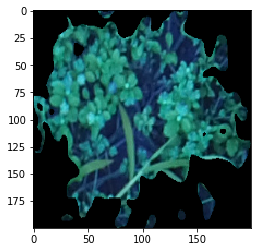

In [9]:
## ploting one image
plt.figure(figsize=(4,4))
plt.imshow(cv2.resize(cv2.imread(all_files[1]), (im_width, im_height)), cmap=plt.cm.gray, interpolation='nearest')


In [10]:
## creating array of training set (X)
X = np.ndarray(shape=(num_data, im_width, im_height, im_channel), dtype=np.float64)

In [11]:
## resizing images
for idx, file in enumerate(all_files):
    X[idx] = cv2.resize(cv2.imread(file), (im_width, im_height))

## splitting into training, validation, and testing set (creating
## empty arrays as placeholders)
X_train = np.empty(shape=(4000, im_width, im_height, im_channel), dtype=np.float64)
X_val = np.empty(shape=(200, im_width, im_height, im_channel), dtype= np.float64)
X_test = np.empty(shape=(200, im_width, im_height, im_channel), dtype=np.float64)

y_train = np.empty(4000)
y_val = np.empty(200)
y_test = np.empty(200)

In [12]:
for i, cls in enumerate(classes):
    X_test[50*i:50*(i+1)] = X[np.where(Y == i)[0][:50]]
    X_val[50*i:50*(i+1)] = X[np.where(Y == i)[0][50:100]]
    X_train[1000*i:1000*(i+1)] = X[np.where(Y == i)[0][100:]]
    
    y_test[50*i:50*(i+1)] = i
    y_val[50*i:50*(i+1)] = i
    y_train[1000*i:1000*(i+1)] = i

del Y
del X

In [13]:
## extracting features
## shuffling training index
train_idxs = np.random.permutation(X_train.shape[0])
y_train = y_train[train_idxs].astype(int)
X_train = X_train[train_idxs]

X_train = np.reshape(X_train, (X_train.shape[0], -1)).astype('float64')
X_test = np.reshape(X_test, (X_test.shape[0], -1)).astype('float64')
X_val = np.reshape(X_val, (X_val.shape[0], -1)).astype('float64')

X_tiny = X_train[100:110].astype('float64')
y_tiny = y_train[100:110].astype(int)
num_dev = 500

X_dev = X_train[0:num_dev].astype('float64')
y_dev = y_train[0:num_dev].astype(int)
print('X_train shape: ', X_train.shape, '| y_train shape: ', y_train.shape)
print('X_test shape: ', X_test.shape, '| y_test shape: ', y_test.shape)
print('X_val shape: ', X_val.shape, '| y_val shape: ', y_val.shape)
print('X_dev shape: ', X_dev.shape, '| y_dev shape: ', y_dev.shape)
print('X_tiny shape: ', X_tiny.shape, '| y_tiny shape: ', y_tiny.shape)

X_train shape:  (4000, 120000) | y_train shape:  (4000,)
X_test shape:  (200, 120000) | y_test shape:  (200,)
X_val shape:  (200, 120000) | y_val shape:  (200,)
X_dev shape:  (500, 120000) | y_dev shape:  (500,)
X_tiny shape:  (10, 120000) | y_tiny shape:  (10,)


In [14]:
# Substract out the mean image
## first: compute the mean image
# mean_image = 128
mean_image = np.mean(X_train, axis=0)

## second substract the mean image from train and test data
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image
X_tiny -= mean_image

## third append the bias dimension using linear algebra tric not for net
print('=====STACK BIAS term=====')
print("X_train shape", X_train.shape)
print("X_test shape", X_test.shape)
print("X_val shape", X_val.shape)
print("X_dev shape", X_dev.shape)
print("X_tiny shape", X_tiny.shape)

=====STACK BIAS term=====
X_train shape (4000, 120000)
X_test shape (200, 120000)
X_val shape (200, 120000)
X_dev shape (500, 120000)
X_tiny shape (10, 120000)


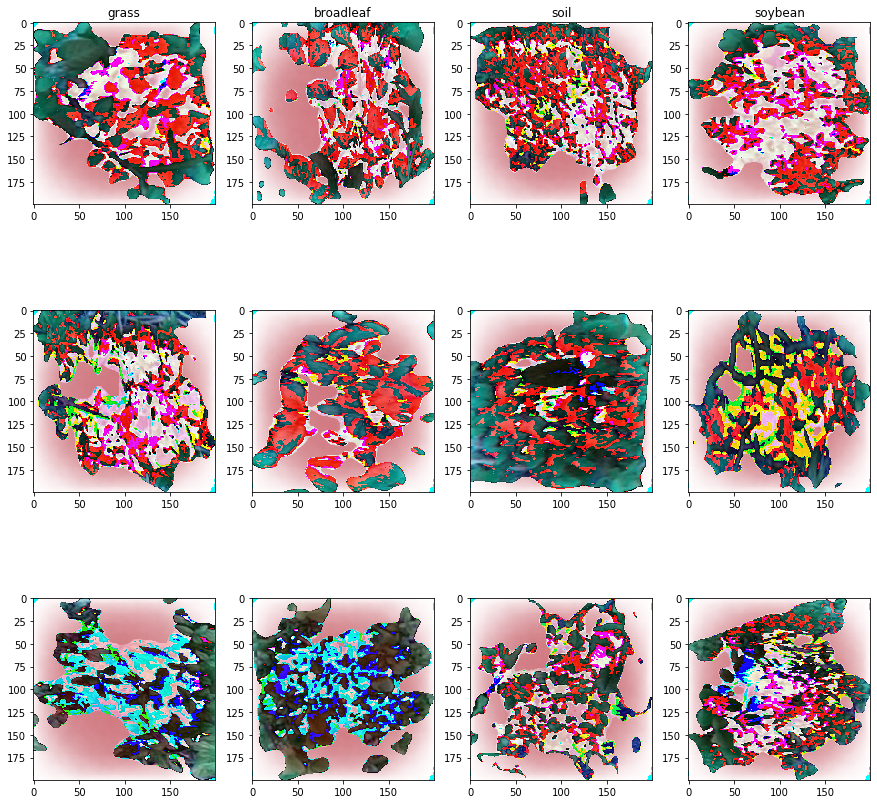

In [15]:
## visualize some images to make sure that everything went ok
n_class =len(classes)
samples_per_class = 3

for y, cls in enumerate(classes):
    idxes = np.flatnonzero(y == y_train)
    idxes = np.random.choice(idxes, samples_per_class, replace = False)
    for i, idx in enumerate(idxes):
        plt_idx = i * n_class + y + 1
        plt.subplot(samples_per_class, n_class, plt_idx)
        plt.imshow(X_train[idx].reshape(im_width, im_height, im_channel).astype('uint8'))
        if (i == 0): plt.title(cls)
            
plt.show()

2. Layer Neural Net: stacked RELU activation function

In [16]:
class TwoLayerNet():
    def __init__(self, input_size, hidden_size, output_size, std=1e-4):
        self.params = {}
        self.params['W1'] = std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = std * np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)
    
    def loss(self, X, y =None, reg=0.0):
        ## defining RELU activation function
        relu = lambda x:np.maximum(0,x)
        
        ##unpacking
        W1, b1 = self.params['W1'], self.params['b1']
        W2, b2 = self.params['W2'], self.params['b2']
        N, D = X.shape
        
        ## forward propagation
        layer1 = relu(X.dot(W1) + b1)
        scores = layer1.dot(W2) + b2
        
        ## if target is not given, then jump out
        if(y is None):
            return scores
        
        ## compute the loss
        ##normalization to prevent overflow when compute exp
        scores -= scores.max()
        scores=np.exp(scores)
        scores_sumexp = np.sum(scores, axis=1)
        
        ## normalize all score
        softmax = scores / scores_sumexp.reshape(N,1)
        ## total loss of all training. og of all correct score
        loss = (-1.0) * np.sum(np.log(softmax[range(N),y]))
        
        ## normalize the loss and add regularization strenght
        loss /= N
        loss += reg * np.sum(W1 * W1)
        loss += reg * np.sum(W2 * W2)
        
        ## backward pass on the net
        grads = {}
        
        correct_class_scores = scores[range(N), y]
        softmax[range(N), y] = (-1.0) * (scores_sumexp - correct_class_scores)/scores_sumexp
        softmax /= N
        
        ## want to find dW2(dL/dW2)
        grads['W2'] = layer1.T.dot(softmax)
        grads['b2'] = np.sum(softmax, axis=0)
        grads['W2'] += reg * 2 * W2
        
        hidden = softmax.dot(W2.T)
        
        ##derivative of max gate
        hidden[layer1 == 0] = 0
        
        grads['W1'] = X.T.dot(hidden)
        grads['b1'] = np.sum(hidden, axis=0)
        grads['W1'] += reg * 2 * W1
        
        return loss, grads
    
    def train(self, X, y, X_val, y_val, learning_rate=1e-3,
             learning_rate_decay=0.95, reg=5e-6, num_iters=100,
             batch_size=200, it_verbose = 1, verbose=False):
        N, D = X.shape
        N_val = X_val.shape[0]
        iteration_per_epoch = max(N/batch_size, 1)
        
        loss_hist = []
        train_acc_hist = []
        val_acc_hist = []
        
        for it in range(num_iters):
            sampling =  np.random.choice(np.arange(N), batch_size, replace=False)
            X_batch = X[sampling]
            y_batch = y[sampling]
            
            ## compute loss and gradients
            loss, grads = self.loss(X_batch, y=y_batch, reg=reg)
            loss_hist.append(loss)
            
            ## update rule
            self.params['W1'] += (-1.0) * learning_rate * grads['W1']
            self.params['b1'] += (-1.0) * learning_rate * grads['b1']
            self.params['W2'] += (-1.0) * learning_rate * grads['W2']
            self.params['b2'] += (-1.0) * learning_rate * grads['b2']
            
            if(verbose and it%it_verbose == 0):
                print('iteration: %d / %d | Loss: %f' % (it, num_iters, loss))
            ## every epoch, check train and val accuracy & decay learning rate   
            if (it % iteration_per_epoch == 0):
                ## check acuracy
                train_acc = (self.predict(X_batch) == y_batch).mean()
                val_acc = (self.predict(X_val) == y_val).mean()
                train_acc_hist.append(train_acc)
                val_acc_hist.append(val_acc)
                
                ## decay learning rate
                learning_rate *= learning_rate_decay
        return {'loss_hist': loss_hist, 'train_acc_hist': train_acc_hist,
               'val_acc_hist': val_acc_hist}
    
    def predict(self, X):
        y_pred = None
        relu = lambda x:np.maximum(0,x)
        ## unpack variables from the params dictionary
        W1, b1 = self.params['W1'], self.params['b1']
        W2, b2 = self.params['W2'], self.params['b2']
        
        ## forward propagation through the network
        layer1 = relu(X.dot(W1) + b1)
        scores = layer1.dot(W2) + b2
        y_pred = np.argmax(scores, axis=1)
        
        return y_pred

In [17]:
input_size = im_width * im_height * im_channel
hidden_size = 200
output_size = n_class
## size initialization parameter
std = 1e-3

net = TwoLayerNet(input_size, hidden_size, output_size, std)
stats = net.train(X_dev, y_dev, X_val, y_val, learning_rate=1e-5,
                  learning_rate_decay=0.95, reg=0.0, num_iters=500, 
                  batch_size=100, it_verbose=10, verbose=True)

iteration: 0 / 500 | Loss: 1.409472
iteration: 10 / 500 | Loss: 1.388722
iteration: 20 / 500 | Loss: 1.393092
iteration: 30 / 500 | Loss: 1.389718
iteration: 40 / 500 | Loss: 1.366299
iteration: 50 / 500 | Loss: 1.372633
iteration: 60 / 500 | Loss: 1.372672
iteration: 70 / 500 | Loss: 1.351332
iteration: 80 / 500 | Loss: 1.342780
iteration: 90 / 500 | Loss: 1.341920
iteration: 100 / 500 | Loss: 1.338137
iteration: 110 / 500 | Loss: 1.361081
iteration: 120 / 500 | Loss: 1.352659
iteration: 130 / 500 | Loss: 1.325069
iteration: 140 / 500 | Loss: 1.313179
iteration: 150 / 500 | Loss: 1.329410
iteration: 160 / 500 | Loss: 1.334631
iteration: 170 / 500 | Loss: 1.327755
iteration: 180 / 500 | Loss: 1.319321
iteration: 190 / 500 | Loss: 1.309845
iteration: 200 / 500 | Loss: 1.321783
iteration: 210 / 500 | Loss: 1.311527
iteration: 220 / 500 | Loss: 1.320359
iteration: 230 / 500 | Loss: 1.325671
iteration: 240 / 500 | Loss: 1.308266
iteration: 250 / 500 | Loss: 1.308278
iteration: 260 / 500 | 

In [18]:
print((net.predict(X_test) == y_test).mean())

0.25


In [19]:
# sanity check, to see how it's predicting
# would likely need more training, dropout, momentum, etc... to build a better model
# give me the indices where the label ['soybean', 'soil', 'grass', 'broadleaf']
indexes = np.flatnonzero(2 == y_train)
print('indices sample: ', indexes[:5])
print('predicts: ', net.predict(X_train[indexes[:5]]))

indices sample:  [ 0  2  4  7 15]
predicts:  [2 1 3 0 2]


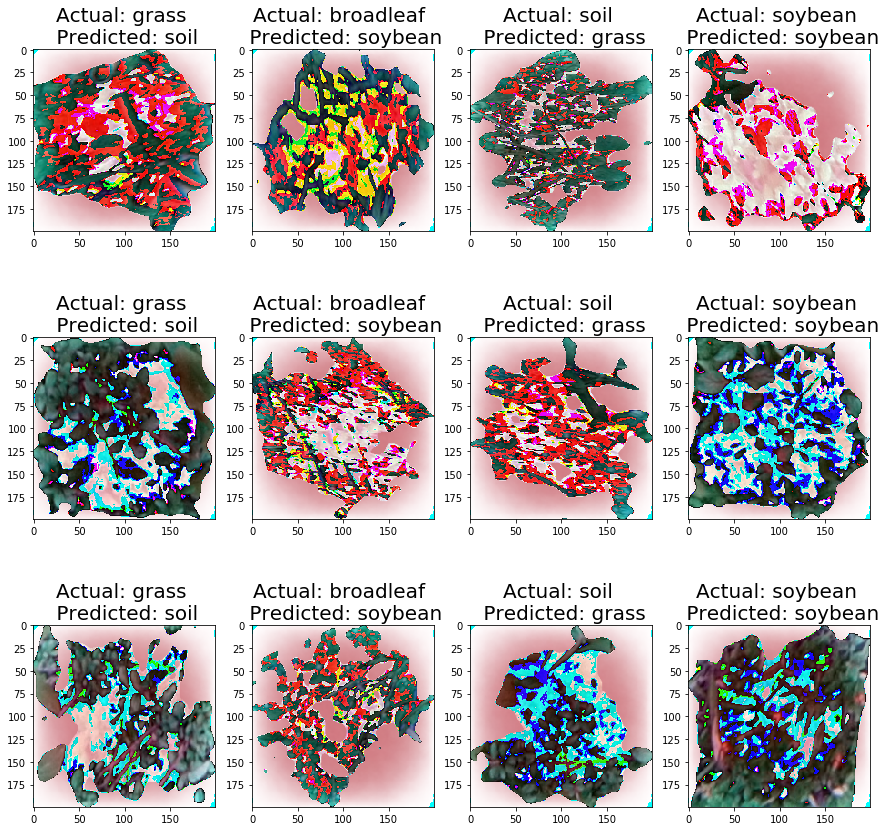

In [20]:
# go through each class in classes: ['soybean', 'soil', 'grass', 'broadleaf']
for y, cls in enumerate(classes):
    # look at sample preds from each class ( variable is y)
    indexes = np.flatnonzero(y == y_train)
    # randomly choose 5 samples per class
    indexes_sample = np.random.choice(indexes, samples_per_class, replace=False)
    # predict their value/label with the model
    prediction = net.predict(X_train[indexes_sample])
    # now plot the actual label vs the predicted label
    for i, idx in enumerate(indexes_sample):
        # this is the column that the class will go into
        # ex. when y==0, it's 'soybean' and the samples in this col are actual soybean but may be pred'd something else
        plt_idx = i * n_class + y + 1
        # this is how many rows to do... 
        plt.subplot(samples_per_class, n_class, plt_idx)
        plt.title(f'Actual: {classes[y]} \n Predicted: {classes[prediction[0]]}', size=20) # the class index is in a list/array, so select the 0th index to get the nunber
        plt.imshow(X_train[idx].reshape(im_width, im_height, im_channel).astype('uint8'))
        
plt.show()

# resources:
1. [normalization of images explained w/ python code](https://arthurdouillard.com/post/normalization/)
1. [how do CNNs work?](https://brohrer.github.io/how_convolutional_neural_networks_work.html)
1. [fastai mooc with good videos](https://course.fast.ai/)
1. [dataset from kaggle](https://www.kaggle.com/fpeccia/weed-detection-in-soybean-crops)
1. [example of neural network from scratch](https://github.com/FlorianWoelki/neural-network-weed-detection)